<a href="https://colab.research.google.com/github/ilenesam/EL_Final-Project/blob/main/EL_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

data = [
    ['C001', 'O1001', '2024-01-05', 450],
    ['C001', 'O1008', '2024-02-12', 1200],
    ['C002', 'O1002', '2024-03-18', 980],
    ['C002', 'O1010', '2024-05-22', 650],
    ['C003', 'O1003', '2024-04-10', 230],
    ['C004', 'O1004', '2024-01-28', 1400],
    ['C004', 'O1011', '2024-07-15', 1750],
    ['C005', 'O1005', '2024-05-19', 670],
    ['C006', 'O1006', '2024-06-05', 850],
    ['C007', 'O1007', '2024-02-14', 420],
    ['C007', 'O1012', '2024-08-03', 380],
    ['C008', 'O1009', '2024-09-20', 1200],
    ['C009', 'O1013', '2024-10-25', 1990],
    ['C010', 'O1014', '2024-03-03', 560],
    ['C010', 'O1015', '2024-04-01', 720],
]

df = pd.DataFrame(data, columns=['customer_id', 'order_id', 'order_date', 'amount'])
df.to_csv('transactions.csv', index=False)

print("✅ transactions.csv created successfully!")


✅ transactions.csv created successfully!


Loading transactions...
Loaded 15 transactions for 10 customers
Observation end date: 2024-07-27 (prediction window: next 90 days)
Training XGBoost regressor...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
MAE: 0.6643, RMSE: 0.6867
Saved model to models/xgb_ltv_model.pkl


KeyError: "['log_total_value', 'log_avg_order_value', 'log_recency'] not in index"

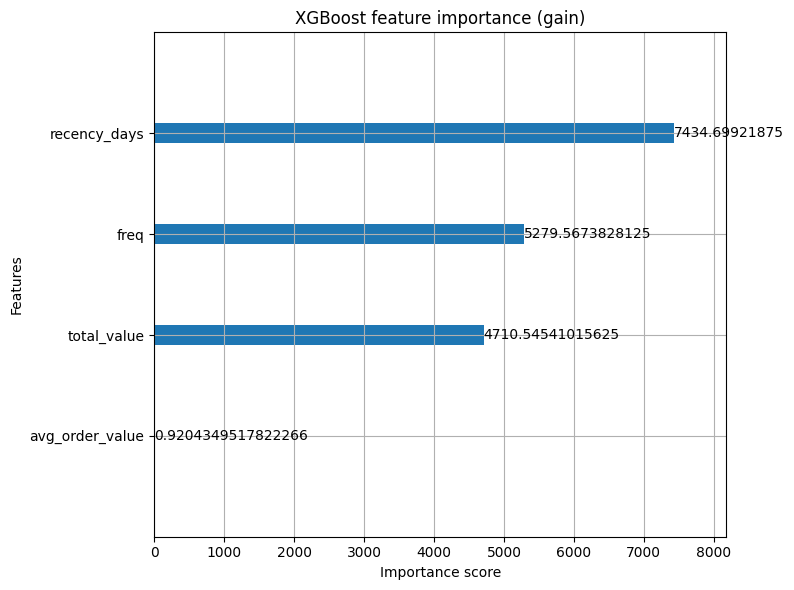

In [ ]:
"""
Customer Lifetime Value Prediction
---------------------------------
This is a ready-to-run Python script / Jupyter notebook code (save as .py or paste into a notebook cell-by-cell).

Deliverables produced by this script:
- Trained model saved to 'models/xgb_ltv_model.pkl'
- Visualizations saved to 'plots/'
- Final LTV predictions saved to 'outputs/ltv_predictions.csv'

Expected input:
- transactions.csv with columns: customer_id, order_id, order_date (YYYY-MM-DD), amount
  Optional: customers.csv with customer-level static features (email, signup_date, etc.)

Dependencies:
- pandas, numpy, scikit-learn, xgboost, joblib, matplotlib
Install with: pip install pandas numpy scikit-learn xgboost joblib matplotlib

Usage:
- Update the PATH_TO_TRANSACTIONS variable to point to your transactions CSV
- Run the script (or run cell-by-cell in a notebook)

Notes:
- This script demonstrates a typical RFM-based LTV estimation approach and trains a regression model
  to predict future customer revenue (LTV) in a holdout period.
- The implementation uses a simple holdout evaluation (train on earlier period, predict later period).

"""

# ---------------------------
# Imports
# ---------------------------
import os
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt

# ---------------------------
# Config / Paths
# ---------------------------
PATH_TO_TRANSACTIONS = 'transactions.csv'  # change as needed
OUTPUT_DIR = 'outputs'
PLOTS_DIR = 'plots'
MODEL_DIR = 'models'
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# ---------------------------
# Helper functions
# ---------------------------

def load_transactions(path):
    df = pd.read_csv(path)
    # normalize column names
    df.columns = [c.strip() for c in df.columns]
    # required columns check
    required = {'customer_id', 'order_id', 'order_date', 'amount'}
    if not required.issubset(set(df.columns)):
        raise ValueError(f"transactions.csv must contain columns: {required}")
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['amount'] = pd.to_numeric(df['amount'], errors='coerce').fillna(0.0)
    return df


def prepare_rfm_features(transactions, reference_date=None, freq_days=365):
    """
    Build RFM-style features from transaction history.
    reference_date: the date to compute 'recency' relative to. If None, uses max(order_date)+1 day.
    freq_days: time window to count frequency (useful for windowed features)
    Returns: features dataframe with index customer_id
    """
    if reference_date is None:
        reference_date = transactions['order_date'].max() + pd.Timedelta(days=1)
    # Aggregate per-customer
    agg = transactions.groupby('customer_id').agg(
        freq=('order_id', 'nunique'),
        total_value=('amount', 'sum'),
        avg_order_value=('amount', 'mean'),
        first_order_date=('order_date', 'min'),
        last_order_date=('order_date', 'max')
    ).reset_index()
    agg['recency_days'] = (reference_date - agg['last_order_date']).dt.days
    agg['customer_age_days'] = (reference_date - agg['first_order_date']).dt.days
    # Frequency in last year (optional): count orders in last freq_days
    cutoff = reference_date - pd.Timedelta(days=freq_days)
    recent = transactions[transactions['order_date'] >= cutoff]
    recent_freq = recent.groupby('customer_id').agg(freq_12m=('order_id', 'nunique')).reset_index()
    agg = agg.merge(recent_freq, on='customer_id', how='left')
    agg['freq_12m'] = agg['freq_12m'].fillna(0).astype(int)
    # Fillna and derived
    agg['avg_order_value'] = agg['avg_order_value'].fillna(0)
    agg['total_value'] = agg['total_value'].fillna(0)
    # Optional: Recency * Frequency interactions
    agg['recency_x_freq'] = agg['recency_days'] * agg['freq_12m']
    return agg, reference_date


def build_label(transactions, observation_end_date, prediction_window_days=90):
    """
    Creates the label (future revenue) for each customer.
    observation_end_date: last date of historical period to compute features (datetime)
    prediction_window_days: length of holdout window to sum revenue as target
    Returns: DataFrame with customer_id and future_revenue
    """
    start = observation_end_date + pd.Timedelta(days=1)
    end = observation_end_date + pd.Timedelta(days=prediction_window_days)
    mask = (transactions['order_date'] >= start) & (transactions['order_date'] <= end)
    future = transactions[mask].groupby('customer_id').agg(future_revenue=('amount', 'sum')).reset_index()
    return future

# ---------------------------
# Main pipeline
# ---------------------------
if __name__ == '__main__':
    print('Loading transactions...')
    tx = load_transactions(PATH_TO_TRANSACTIONS)
    print(f'Loaded {len(tx)} transactions for {tx["customer_id"].nunique()} customers')

    # Choose an observation cutoff - e.g., use the last 180 days as prediction window and everything before as train
    prediction_window_days = 90
    observation_end = tx['order_date'].max() - pd.Timedelta(days=prediction_window_days)
    print(f'Observation end date: {observation_end.date()} (prediction window: next {prediction_window_days} days)')

    # Split transactions into history (<= observation_end) and future (> observation_end)
    history = tx[tx['order_date'] <= observation_end].copy()
    future = tx[tx['order_date'] > observation_end].copy()

    # Feature engineering using history
    features_df, ref_date = prepare_rfm_features(history, reference_date=observation_end)

    # Build target label using future window
    labels_df = build_label(tx, observation_end, prediction_window_days=prediction_window_days)

    # Merge features with labels
    data = features_df.merge(labels_df, on='customer_id', how='left')
    data['future_revenue'] = data['future_revenue'].fillna(0.0)

    # Some basic features and optional transformations
    data['log_total_value'] = np.log1p(data['total_value'])
    data['log_avg_order_value'] = np.log1p(data['avg_order_value'])
    data['log_recency'] = np.log1p(data['recency_days'])

    feature_cols = [
        'freq', 'freq_12m', 'total_value', 'avg_order_value', 'recency_days',
        'customer_age_days', 'recency_x_freq', 'log_total_value', 'log_avg_order_value', 'log_recency'
    ]

    X = data[feature_cols].fillna(0)
    y = data['future_revenue']

    # Train/test split
    X_train, X_test, y_train, y_test, customers_train, customers_test = train_test_split(
        X, y, data['customer_id'], test_size=0.2, random_state=42)

    print('Training XGBoost regressor...')
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=4, random_state=42)
    params = {
        'n_estimators': [100, 300],
        'max_depth': [4, 6],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0]
    }
    # small grid search (can be expanded)
    grid = GridSearchCV(xgb_model, params, cv=3, scoring='neg_mean_absolute_error', n_jobs=1, verbose=1)
    grid.fit(X_train, y_train)

    print('Best params:', grid.best_params_)
    best_model = grid.best_estimator_

    # Evaluate
    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')

    # Feature importance plot
    try:
        fig, ax = plt.subplots(figsize=(8,6))
        xgb.plot_importance(best_model, ax=ax, importance_type='gain', max_num_features=20)
        ax.set_title('XGBoost feature importance (gain)')
        fig.tight_layout()
        fig.savefig(os.path.join(PLOTS_DIR, 'feature_importance.png'))
    except Exception as e:
        print('Could not plot feature importances:', e)

    # Save trained model
    joblib.dump(best_model, os.path.join(MODEL_DIR, 'xgb_ltv_model.pkl'))
    print('Saved model to', os.path.join(MODEL_DIR, 'xgb_ltv_model.pkl'))

    # Predict LTV for all customers (use latest features computed on latest available date)
    # Recompute features using entire history up to tx.max - prediction_window_days (same as before)
    all_features, _ = prepare_rfm_features(tx[tx['order_date'] <= observation_end], reference_date=observation_end)
    X_all = all_features[feature_cols].fillna(0)
    all_features['predicted_ltv'] = best_model.predict(X_all)

    # Segment customers based on predicted LTV into quartiles
    all_features['ltv_segment'] = pd.qcut(all_features['predicted_ltv'].rank(method='first'), q=4, labels=['D', 'C', 'B', 'A'])

    # Save predictions
    output_path = os.path.join(OUTPUT_DIR, 'ltv_predictions.csv')
    all_features[['customer_id', 'predicted_ltv', 'ltv_segment', 'freq', 'freq_12m', 'total_value', 'avg_order_value', 'recency_days']].to_csv(output_path, index=False)
    print('Saved predictions to', output_path)

    # Save evaluation CSV for test split
    eval_df = pd.DataFrame({
        'customer_id': customers_test,
        'actual': y_test,
        'predicted': y_pred
    })
    eval_df.to_csv(os.path.join(OUTPUT_DIR, 'ltv_eval_test.csv'), index=False)

    # Plot actual vs predicted
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(y_test, y_pred, alpha=0.4)
    ax.set_xlabel('Actual future revenue')
    ax.set_ylabel('Predicted future revenue')
    ax.set_title('Actual vs Predicted LTV')
    # Plot y=x line
    maxv = max(y_test.max(), y_pred.max())
    ax.plot([0, maxv], [0, maxv], linestyle='--')
    fig.tight_layout()
    fig.savefig(os.path.join(PLOTS_DIR, 'actual_vs_predicted.png'))
    print('Saved plots to', PLOTS_DIR)

    # Summary metrics file
    metrics = {
        'mae': mae,
        'rmse': rmse,
        'best_params': grid.best_params_
    }
    pd.Series(metrics).to_csv(os.path.join(OUTPUT_DIR, 'metrics_summary.csv'))

    print('\nPipeline complete. Outputs:')
    print('- Model: ', os.path.join(MODEL_DIR, 'xgb_ltv_model.pkl'))
    print('- Predictions CSV:', output_path)
    print('- Evaluation CSV:', os.path.join(OUTPUT_DIR, 'ltv_eval_test.csv'))
    print('- Plots directory:', PLOTS_DIR)

# End of script
